## Histogram of best-fit values separated by process model
This should be included in an Appendix, in response to some questions from reviewers.  Task has already been accomplished in `multi_catchment-BIC_histo-permodel.py`.  Putting in a notebook here to try to iterate on workflow.

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from matplotlib import cm
import glob

In [50]:
model_names = ['ANICE-ITM_Berends', 'CESM_kampenhout', 'dEBM_krebs','HIRHAM_mottram', 
                'NHM-SMAP_niwano', 'RACMO_noel', 'SNOWMODEL_liston']

## Specify filepath pattern of series.  
## This will be fed to glob later (hence *) 
## and looped over catchment number (hence {} awaiting .format())
series_path = '/Users/lizz/Documents/GitHub/Data_unsynced/SMBMIP-processed/*-catchment_{}_mean-tseries.csv'

In [51]:
## Read in time series
def read_catchment_series(fpath, anomaly=True):
    catchment_fpath = fpath
    catchment_tseries = pd.read_csv(catchment_fpath, index_col=0, parse_dates=[0])
    catchment_tseries.mask(catchment_tseries>1e30)
    anomaly_series = catchment_tseries - catchment_tseries.mean()
    if anomaly:
        return anomaly_series
    else:
        return catchment_tseries

def fit_catchment_series(tseries, which_model, comparison_n=range(0,6), 
                         hold_back=None, seasonal=True):
    bic_per_n = pd.DataFrame(index=comparison_n, columns=model_names)
    
    if 'multi' in which_model:  ## allow multi-model mode reporting
        for m in model_names:
            for n in comparison_n:
                mod = AutoReg(tseries[m], n, trend='ct', 
                              hold_back=hold_back, seasonal=seasonal)
                results = mod.fit()
                bic_per_n[m][n] = results.bic
            bic_per_n[m] = pd.to_numeric(bic_per_n[m])
        best_n = bic_per_n.idxmin().mode()[0]
    else:
        for n in comparison_n:
            mod = AutoReg(tseries[which_model], n, trend='ct', 
                          hold_back=hold_back, seasonal=seasonal)
            results = mod.fit()
            bic_per_n[which_model][n] = results.bic
        bic_per_n[which_model] = pd.to_numeric(bic_per_n[which_model])
        best_n = bic_per_n[which_model].idxmin()
    
    bic_difference = bic_per_n.transform(lambda x: x-x.min())
    
    return best_n, bic_difference

In [52]:
import warnings
warnings.filterwarnings(action='ignore')

We ignore warnings for now, because statsmodels is going to complain about parameter names.  This does not affect our results.  If you are debugging and want to see warnings, you can set `action=once` instead.

In [53]:
Ns_annual_bymodel = {m: [] for m in model_names}
bic_vs_ar0_bymodel = {m: [] for m in model_names}
non0_count = 0

for i in range(0, 260):
    ctmt_fpath = glob.glob(series_path.format(i))[0]
    s = read_catchment_series(ctmt_fpath)
    a = s.resample('A').sum()
    if a.isna().sum().sum()>0:
        print('NaNs found in catchment {}'.format(i))
        continue
    else:
        for m in model_names:
            n2, b = fit_catchment_series(a, which_model=m, comparison_n=range(0,6),
                                         hold_back=5, seasonal=False)
            Ns_annual_bymodel[m].append(n2)
            if n2!=0: # note BIC difference for non-white noise choices
                non0_count +=1
                bva = b.loc[0] - b.loc[n2] # difference between chosen fit and AR(1)
                bic_vs_ar0_bymodel[m].append(bva[m])

In [54]:
bic_vs_ar0

[25.48742407065606,
 1.2204002619717471,
 2.2365073652789533,
 35.484037601181626,
 35.48403760118174,
 35.48403760118174,
 35.48403760118174,
 35.48403760118174,
 35.48403760118174,
 35.48403760118174,
 4.123349340456684,
 1.3218099688680809,
 25.48742407065606,
 25.48742407065606,
 25.48742407065606,
 25.48742407065606,
 25.48742407065606,
 25.48742407065606,
 25.48742407065606,
 25.48742407065606,
 0.41305289533801215,
 25.48742407065606,
 4.831594494774947,
 25.487424070655948,
 35.484037601181626,
 0.7405000829863866,
 0.30424433753501035,
 9.173349275736314,
 1.9732194922119675,
 35.484037601181626,
 0.3473432463867425,
 1.204613608721445,
 0.34114985249556184,
 0.05414491978257274,
 1.085836464606416,
 0.11158290580260655,
 0.8436885883679679,
 25.48742407065606,
 25.48742407065606,
 25.48742407065606,
 25.48742407065606,
 25.48742407065606,
 35.484037601181626,
 25.487424070656175,
 25.487424070656175,
 25.487424070656175,
 25.487424070656175,
 25.487424070656175,
 35.484037601

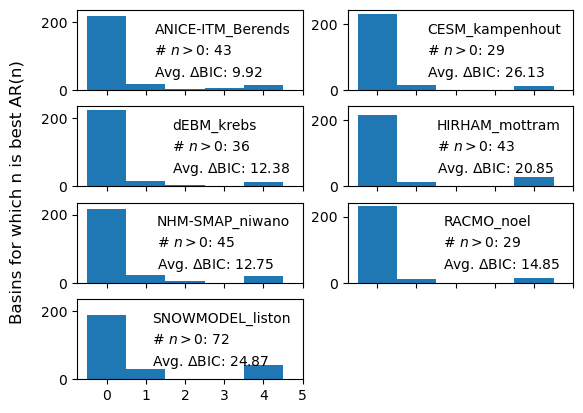

In [63]:
import matplotlib as mpl
from matplotlib.patches import Patch
mpl.rcParams['legend.frameon'] = 'False'


fig, axs = plt.subplots(4,2, sharey=True, sharex=True)
for i, m in enumerate(model_names):
    ax = axs.ravel()[i]
    ax.hist(Ns_annual_bymodel[m], bins=range(0,6), align='left')
    ax.set(xticks=(0, 1, 2, 3, 4, 5)
            )
    
    ## Compute the number of non-0 fits
    non0_count_m = len(bic_vs_ar0_bymodel[m])
    bic_diff = np.mean(bic_vs_ar0_bymodel[m])
    
    ## custom legend to add annotation
    legend_elements = [Patch(facecolor=None, edgecolor=None,visible=False,label=m),
                      Patch(facecolor=None, edgecolor=None,
                            visible=False,label=r'# $n>0$: {}'.format(non0_count_m)),
                        Patch(facecolor=None, edgecolor=None,
                              visible=False,label=r'Avg. $\Delta$BIC: {:.2f}'.format(bic_diff))
                      ] 

    ax.legend(handles=legend_elements, loc='upper right')

axs[2,1].set(xticks=(0, 1, 2, 3, 4, 5), xticklabels=(0, 1, 2, 3, 4, 5))
axs[-1,-1].axis('off')
fig.supylabel('Basins for which n is best AR(n)')
plt.show()  

In [56]:
non0_count

297

In [57]:
for m in model_names:
    print(np.mean(bic_vs_ar0_bymodel[m]))

9.92341062957595
26.126550777021976
12.380868477641902
20.85052884996158
12.7454206858425
14.847275429190296
24.871033657922606
